<a href="https://colab.research.google.com/github/Servat0r/ISPR-Midterms-2023/blob/master/Midterm1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Midterm 1 ISPR 2023 - Assignment 6 - Salvatore Correnti (m. 584136)
In this assignment we will show the implementation and testing on different images of an image blob detector based on the `Laplacian of Gaussian` convolution filter.

## Initial imports
Before coding, we use a single cell for changing working directory to the one in which this notebook is contained and for all the imports for simplyfing reading.

In [1]:
%cd ./drive/MyDrive/Github/ISPR-Midterms-2023

/content/drive/MyDrive/Github/ISPR-Midterms-2023


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 # for converting BGR -> grayscale
from scipy.signal import convolve2d  # 2d-convolution operator
from skimage.exposure import rescale_intensity
from PIL import Image
from typing import * # for function signatures

## Definition and Implementation of LoG
We first define the `Laplacian of Gaussian` operator as the sum of the diagonal elements of the Jacobian matrix of the Gaussian function:

$$g_{\sigma}(x, y) := \dfrac{1}{2\pi\sigma^2}e^{-\left(\dfrac{x^2 + y^2}{2\sigma^2}\right)}$$.

$$\nabla g_{\sigma}(x, y) = -\dfrac{g_{\sigma}(x,y)}{\sigma^2}\left[\begin{array}{c} x \\ y \end{array}\right]$$

$$\nabla^2g_{\sigma}(x,y) = \dfrac{\partial^2 g_{\sigma}}{\partial x^2} + \dfrac{\partial^2 g_{\sigma}}{\partial y^2} = \dfrac{e^{-\left(\dfrac{x^2 + y^2}{2\sigma^2}\right)}}{\pi\sigma^4}\left[\dfrac{x^2 + y^2}{2\sigma^2} - 1\right]\:\:(1)$$


As we can see in (1), the sign of $\nabla^2 g_{\sigma}$ is determined by the value of $x^2 + y^2$, which can be interpreted as the radius of a circle centered in $(0, 0)$ to which $(x, y)$ belongs, and in particular $\nabla^2 g_{\sigma}$ when this radius is equal to $\sigma\sqrt{2}$, for which in fact the $\nabla^2 g_{\sigma}$ used as convolutional filter has the maximum response.

Since we are operating with discrete values like images, we need to define a `kernel`, which is a matrix $M \in \mathbb{R^{(2n+1) \times (2n+1)}}$ such that $M_{n+1 \pm i, n+1 \pm j} = f(\pm i, \pm j)$ for a given function $f$.

In [171]:
def log_filter(window_size: int, sigma: float = 1.0):
  """
  :param window_size: Size of the kernel window.
  :param sigma: Variance (sigma) of the LoG filter.
  """
  w1 = h1 = window_size // 2  # In case of odd window, will give 0 to central value
  w2 = h2 = window_size - w1
  x, y = np.arange(-w1, w2, 1), np.arange(-h1, h2, 1)
  mg = np.meshgrid(x, y)
  # Compute the (x^2+y^2/(2sigma^2)) matrix
  r = (np.square(mg[0][:, :]) + np.square(mg[1][:, :]))/(2 * sigma**2)
  # Now compute the exp(r) matrix
  gs = np.exp(-r)
  result = 1.0/(np.pi * sigma**4) * (gs * (r - 1.0)) # * for elementwise product
  return result.astype(np.float32)

An example of LoG matrix for a 3x3 kernel:

In [4]:
log_filter(3, 1.0)

array([[ 0.        , -0.09653235,  0.        ],
       [-0.09653235, -0.31830989, -0.09653235],
       [ 0.        , -0.09653235,  0.        ]])

## Dataset
For performing convolutions we will use the following dataset:

http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip

Since its whole dimension is of about 125 MB, (by now) the whole dataset is stored in the same folder of this notebook.

We will now define some utilities for our task:

In [5]:
def load_image(dir_path: str, file_name: str):
  return Image.open(os.path.join(dir_path, file_name)).convert('L')

def get_image_array(arr: np.ndarray, show=False):
  image = Image.fromarray(arr)
  if show:
    image.show()
  return image

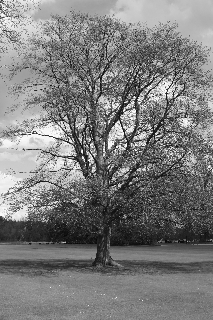

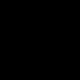

In [175]:
img = load_image('MSRC_ObjCategImageDatabase_v1', '2_10_s.bmp')
img.show()

black_image_arr = np.zeros((80, 80), np.uint8)
pil_black_image = get_image_array(black_image_arr, True)

In [172]:
def convolve_image(
    image: Image, kernel: np.ndarray,
    convolver: Callable[[np.ndarray, np.ndarray], np.ndarray]=convolve2d
):
  """
  Given a grayscale PIL image, converts it to array and convolves
  it with the given kernel.
  :param image: PIL Image to be convolved.
  :param kernel: numpy kernel to use for convolution.
  :param convolver: Function of the form (img, kernel) -> conv_img to use
  for performing convolution. Defaults to `scipy.signal.convolve2d`.
  :return: Convolved image as np.uint8 array.
  """
  img_arr = np.asarray(image)#.astype(np.float32)  # It is better to actually convolve with double values
  conv_img = convolver(img_arr, kernel)
  conv_img = conv_img.astype(np.uint8)
  return conv_img

In [81]:
def cv2_convolver(src, kernel):
  out = cv2.filter2D(src, -1, kernel)
  return out

In [ ]:
kernel = log_filter(13, 1)
conv_image = convolve_image(img, kernel)
pil_conv_image = get_image_array(conv_image, True)